In [46]:
import math
import ssl
import urllib.request

import certifi
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.utils
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from tqdm import tqdm
from tqdm.auto import tqdm

from deviceUtility import get_best_available_device

# Fix SSL certificate issue
ssl_context = ssl.create_default_context(cafile=certifi.where())
urllib.request.install_opener(urllib.request.build_opener(urllib.request.HTTPSHandler(context=ssl_context)))

gpu = get_best_available_device()

________________________

Device manager:
Running on device: mps
________________________


### Constants

In [47]:
TIME_STEP = 1000
EPOCH_NUM = 30
LEARNING_RATE = 1e-4

# Set according to DDPM paper
BETA_START = 1e-4
BETA_END = 0.02

BATCH_SIZE = 32

### Precalculations

In [48]:
betas = torch.linspace(BETA_START, BETA_END, TIME_STEP, device=gpu)  # Linear Variance Scheduler
alphas = 1. - betas
alphas_cum_prod = torch.cumprod(alphas, 0)
alphas_cum_prod_prev = F.pad(alphas_cum_prod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cum_prod = torch.sqrt(alphas_cum_prod)
sqrt_one_minus_alphas_cum_prod = torch.sqrt(1. - alphas_cum_prod)
posterior_variance = betas * (1. - alphas_cum_prod_prev) / (1. - alphas_cum_prod)

### Helper functions

In [66]:
def extract(equation, timestep, x_shape):
    """
    Extracts the values of the equation for the given timestep for every image in the batch.
    """
    size = timestep.shape[0]
    out = equation.gather(-1, timestep.to(gpu))
    return out.reshape(size, *((1,) * (len(x_shape) - 1))).to(timestep.device)


def q_sample(image_batch, timestep, noise=None):
    """
    Forward pass of the diffusion model.
    Adds noise to an image at time t.
    If noise is not provided, it is sampled from a standard normal distribution.
    """
    if noise is None:
        noise = torch.randn_like(image_batch)

    # Extract the values for every image in the batch for the given timestep
    sqrt_alphas_cum_prod_t = extract(sqrt_alphas_cum_prod, timestep, image_batch.shape)
    sqrt_one_minus_alphas_cum_prod_t = extract(sqrt_one_minus_alphas_cum_prod, timestep, image_batch.shape)

    return sqrt_alphas_cum_prod_t * image_batch + sqrt_one_minus_alphas_cum_prod_t * noise


@torch.no_grad()
def p_sample(model, x, t, t_index):
    """
    Reverse pass of the diffusion model.
    Given an image at time t, it predicts the image at time t-1.
    """
    betas_t = extract(betas, t, x.shape)

    sqrt_one_minus_alphas_cum_prod_t = extract(
        sqrt_one_minus_alphas_cum_prod, t, x.shape
    )

    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cum_prod_t)

    if t_index == 0:
        return model_mean
    else:
        """
        Helps determine amount of noise to remove from the image.
        """
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model, shape):
    device = gpu
    b = shape[0]
    img = torch.randn(shape, device=device)  # Random noised image

    for i in tqdm(reversed(range(0, TIME_STEP)), desc='Sampling loop time step.', total=TIME_STEP):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)

    return img


def p_losses(denoise_model, x_start, timestep, noise=None, loss_type="l1"):
    # If noise is not provided, create noise similar to the input image
    if noise is None:
        noise = torch.randn_like(x_start)

    # Input image with the random noise and the timestep
    x_noisy = q_sample(x_start, timestep, noise)

    # Feed the noisy image to the denoise model to predict the noise
    predicted_noise = denoise_model(x_noisy, timestep)

    # Calculate the loss between the predicted noise and the actual noise
    if loss_type == 'l1':
        model_loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        model_loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        model_loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return model_loss


### Sinusoidal Positional Embedding
As parameter of neural network are 
shared across time one should employ 
a sinusoidal embedding to encode the position of the input. 
Makes the neural network know which timestep it is at.

In [50]:
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(SinusoidalPositionalEmbedding, self).__init__()
        self.embedding_dim = embedding_dim

    def forward(self, t):
        # Create a sinusoidal embedding for each position in time
        half_dim = self.embedding_dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, dtype=torch.float32, device=gpu) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
        return emb.to(gpu)

### Convolutional Layer
Classes which define the building blocks of the UNet architecture.
Consists of double convolutional layers with ReLU activation functions.
Also includes a time embedding layer which is added to the output of the first convolutional layer.

In [51]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super(Block, self).__init__()

        self.time_mlp = nn.Sequential(
            SinusoidalPositionalEmbedding(time_emb_dim),
            nn.Linear(time_emb_dim, out_channels),
            nn.ReLU(inplace=True)
        )

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x, t):
        # First convolution
        h = self.relu(self.conv1(x))

        # Compute time embedding and reshape to match spatial dimensions
        time_emb = self.time_mlp(t)
        time_emb = time_emb[(...,) + (None,) * 2]  # Shape (batch, channels, 1, 1)

        # Add time embedding
        h = h + time_emb

        # Second convolution
        h = self.relu(self.conv2(h))
        return h

### U-net
The UNet architecture for approximating the means of the posterior distribution.
The architecture consists of a contracting path, a bottleneck, and an expanding path.

In [52]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.time_emb_dim = 32
        self.max_pool = nn.MaxPool2d(2, 2)

        # Contracting path
        self.encoder1 = Block(1, 64, self.time_emb_dim)
        self.encoder2 = Block(64, 128, self.time_emb_dim)

        # Bottleneck
        self.bottleneck = Block(128, 256, self.time_emb_dim)

        # Expanding path
        self.up_convolution_3 = nn.ConvTranspose2d(256, 128, kernel_size=2,
                                                   stride=2)
        self.up_convolution_4 = nn.ConvTranspose2d(128, 64, kernel_size=2,
                                                   stride=2)

        self.decoder3 = Block(256, 128, self.time_emb_dim)
        self.decoder4 = Block(128, 64, self.time_emb_dim)

        self.output_layer = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, t):
        # Contracting path
        enc1_out = self.encoder1(x, t)
        pool_enc1_out = self.max_pool(enc1_out)

        enc2_out = self.encoder2(pool_enc1_out, t)
        pool_enc2_out = self.max_pool(enc2_out)

        # Bottleneck
        bottle_out = self.bottleneck(pool_enc2_out, t)

        # Expanding path
        up_conv_3_out = self.up_convolution_3(bottle_out)
        crop_up_conv_3_out = crop_tensor(enc2_out, up_conv_3_out)
        dec3_out = self.decoder3(
            torch.cat([up_conv_3_out, crop_up_conv_3_out], dim=1), t)

        up_conv_4_out = self.up_convolution_4(dec3_out)
        crop_up_conv_4_out = crop_tensor(enc1_out, up_conv_4_out)
        dec4_out = self.decoder4(
            torch.cat([up_conv_4_out, crop_up_conv_4_out], dim=1), t)

        output = self.output_layer(dec4_out)

        return output


def crop_tensor(tensor, target_tensor):
    """Make the tensor the same size as the target tensor by cropping."""
    target_size = target_tensor.size()[2:]
    tensor_size = tensor.size()[2:]
    delta_h = (tensor_size[0] - target_size[0]) // 2
    delta_w = (tensor_size[1] - target_size[1]) // 2
    return tensor[:, :, delta_h:tensor_size[0] - delta_h,
           delta_w:tensor_size[1] - delta_w]

### Load data

In [53]:
image_size = 28
channels = 1  # Grey scale

transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(), # Said in paper to help with training
     transforms.ToTensor(),
     transforms.Lambda(lambda x: (x * 2) - 1), # Normalize to [-1, 1]
     ]
)

mnist = MNIST(root='.', train=True, download=True, transform=transform)

class DatasetWrapper(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]  # Ignore the label
        return image

dataloader = DataLoader(DatasetWrapper(mnist), batch_size=BATCH_SIZE, shuffle=True)

### Training model


In [59]:
# Train model
model = UNet().to(gpu)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

with tqdm(range(0, EPOCH_NUM), desc="Epochs", total=EPOCH_NUM) as epoch_progress:
    for epoch in epoch_progress:
        for step, batch in enumerate(dataloader):  # Iterate over every batch in the dataloader
            optimizer.zero_grad()

            # Get the batch size and move the batch to the device
            batch_size = batch.shape[0]
            batch = batch.to(gpu)

            # Algorithm 1 line 3: sample t uniformly for every example in the batch
            t = torch.randint(0, TIME_STEP, (batch_size,), device=gpu).long()

            loss = p_losses(model, batch, t)

            # If the step is a multiple of 100, print the loss
            if step % 100 == 0:
                epoch_progress.set_postfix(loss=loss.item())

            # Algorithm 1 line 5: backpropagate the loss
            loss.backward()

            # Algorithm 1 line 6: update the weights
            optimizer.step()


Epochs: 100%|██████████| 30/30 [22:37<00:00, 45.25s/it, loss=0.0518]


### Generate images


Sampling loop time step.: 100%|██████████| 1000/1000 [00:06<00:00, 162.37it/s][A


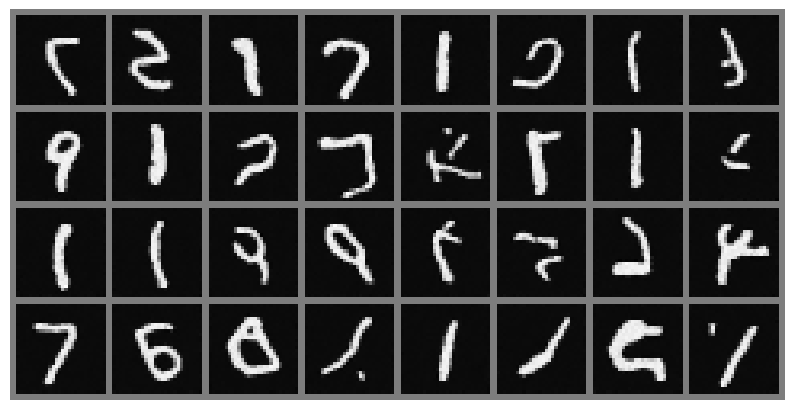

In [61]:
samples = p_sample_loop(model, shape=(BATCH_SIZE, channels, image_size, image_size))

plt.figure(figsize=(10, 10))
plt.axis("off")

plt.imshow(torchvision.utils.make_grid(samples, nrow=8).cpu().detach().numpy()[0], cmap='gray')

In [67]:
import os
import torch
import torchvision.transforms as T

amount = 200
samples = p_sample_loop(model, shape=(amount, channels, image_size, image_size))
path = "./generated_images"
os.makedirs(path, exist_ok=True)

transform = T.ToPILImage(mode="L")

def save_tensor_as_image(tensor, filename="./generated_images"):
    tensor = torch.clamp(tensor, 0, 1)
    for i, tensor in enumerate(tensor):
        img = transform(tensor)
        img.save(os.path.join(path, f"{filename}{i}.png"))


save_tensor_as_image(samples, "sample")

Sampling loop time step.: 100%|██████████| 1000/1000 [00:37<00:00, 26.77it/s]
